# 04. Semi-supervised AQI Classification — Self-Training

- Mục tiêu: chạy self-training để **tăng lượng nhãn** cho AQI khi thiếu nhãn.
- Output: metrics JSON + sample predictions + sample alerts.
- Mini project: sweep TAU / LABEL_MISSING_FRACTION và so sánh với baseline supervised.

## Bước 1. Cấu các tham số

In [17]:
SEMI_DATASET_PATH = "data/processed/02_dataset_for_semi.parquet"
CUTOFF = "2017-01-01"

TAU = 0.9
MAX_ITER = 10
MIN_NEW_PER_ITER = 20
VAL_FRAC = 0.20
RANDOM_STATE = 42

METRICS_PATH = "data/processed/04_metrics_self_training.json"
PRED_SAMPLE_PATH = "data/processed/04_predictions_self_training_sample.csv"
ALERTS_SAMPLE_PATH = "data/processed/04_alerts_self_training_sample.csv"

ALERT_FROM_CLASS = "Unhealthy"

In [18]:
from pathlib import Path
import json
import sys
import pandas as pd
import matplotlib.pyplot as plt

# Find project root and add to path BEFORE importing from src
PROJECT_ROOT = Path(".").resolve()
if not (PROJECT_ROOT / "data").exists() and (PROJECT_ROOT.parent / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent.resolve()

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.semi_supervised_library import (
    SemiDataConfig, SelfTrainingConfig, run_self_training, add_alert_columns
)

In [19]:
df = pd.read_parquet((PROJECT_ROOT / SEMI_DATASET_PATH).resolve())

data_cfg = SemiDataConfig(cutoff=CUTOFF, random_state=int(RANDOM_STATE))
st_cfg = SelfTrainingConfig(
    tau=float(TAU),
    max_iter=int(MAX_ITER),
    min_new_per_iter=int(MIN_NEW_PER_ITER),
    val_frac=float(VAL_FRAC),
)

## Bước 2. Chạy thuật toán

In [20]:
# --- Đường dẫn file cache ---
# File JSON để lưu metadata và các kết quả nhỏ
RESULT_CACHE_PATH = PROJECT_ROOT / "data" / "processed" / "04_result_after_running_selft_training.json"
# File Parquet để lưu DataFrame dự đoán hiệu quả hơn
PRED_DF_CACHE_PATH = PROJECT_ROOT / "data" / "processed" / "04_result_pred_df.parquet"

# --- Hàm kiểm tra cấu hình (phiên bản sửa lỗi) ---
def check_config_match(cached_cfg_dict, current_cfg_obj):
    """
    So sánh tường minh từng tham số, xử lý trường hợp tuple vs list.
    """
    if not cached_cfg_dict:
        return False
    
    current_cfg_dict = current_cfg_obj.__dict__
    
    # 1. So sánh bộ key (tên các tham số)
    if set(cached_cfg_dict.keys()) != set(current_cfg_dict.keys()):
        print("   - Thay đổi về bộ tham số cấu hình.")
        return False
        
    # 2. So sánh giá trị của từng tham số
    for key, current_value in current_cfg_dict.items():
        cached_value = cached_cfg_dict[key]
        
        # Xử lý đặc biệt: Chuyển tuple thành list trước khi so sánh
        if isinstance(current_value, tuple):
            if list(current_value) != cached_value:
                print(f"   - Thay đổi ở tham số '{key}': cache='{cached_value}' vs. current='{current_value}'")
                return False
        # So sánh các giá trị khác
        elif current_value != cached_value:
            print(f"   - Thay đổi ở tham số '{key}': cache='{cached_value}' vs. current='{current_value}'")
            return False
            
    return True

# --- Logic kiểm tra cache ---
use_cache = False
if RESULT_CACHE_PATH.exists() and PRED_DF_CACHE_PATH.exists():
    print(f"Đã tìm thấy file cache tại: {RESULT_CACHE_PATH}")
    with open(RESULT_CACHE_PATH, 'r', encoding='utf-8') as f:
        cached_data = json.load(f)
    
    # So sánh các tham số đã lưu với tham số hiện tại một cách tường minh
    is_data_cfg_match = check_config_match(cached_data.get('data_cfg'), data_cfg)
    is_st_cfg_match = check_config_match(cached_data.get('st_cfg'), st_cfg)

    if is_data_cfg_match and is_st_cfg_match:
        print("✅ Các tham số khớp. Tải kết quả từ cache.")
        use_cache = True
        
        # Tái tạo biến 'out' từ dữ liệu cache
        out = {
            "history": cached_data['history'],
            "test_metrics": cached_data['test_metrics'],
            "model_info": cached_data['model_info'],
            "pred_df": pd.read_parquet(PRED_DF_CACHE_PATH)
        }
    else:
        print("⚠️ Các tham số đã thay đổi. Chạy lại thuật toán...")
else:
    print("Không tìm thấy file cache. Chạy thuật toán lần đầu...")

# --- Chạy thuật toán hoặc tải từ cache ---
if not use_cache:
    # Chạy thuật toán chính
    out = run_self_training(df, data_cfg, st_cfg)

    # Lưu kết quả mới vào cache
    print("\n💾 Đang lưu kết quả mới vào cache...")
    
    # 1. Lưu DataFrame dự đoán ra file Parquet
    out['pred_df'].to_parquet(PRED_DF_CACHE_PATH)

    # 2. Chuẩn bị và lưu các thông tin còn lại ra file JSON
    payload_to_cache = {
        "data_cfg": data_cfg.__dict__,
        "st_cfg": st_cfg.__dict__,
        "history": out["history"],
        "test_metrics": out["test_metrics"],
        "model_info": out["model_info"],
    }
    
    with open(RESULT_CACHE_PATH, "w", encoding="utf-8") as f:
        json.dump(payload_to_cache, f, ensure_ascii=False, indent=2)
    
    print(f"   Đã lưu cache thành công.")

# Hiển thị một phần kết quả để xác nhận
print("\n--- Hoàn thành thực thi thuật toán ---")
print("5 dòng đầu của DataFrame dự đoán (pred_df):")
display(out['pred_df'].head())


Đã tìm thấy file cache tại: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\data\processed\04_result_after_running_selft_training.json
✅ Các tham số khớp. Tải kết quả từ cache.

--- Hoàn thành thực thi thuật toán ---
5 dòng đầu của DataFrame dự đoán (pred_df):


,datetime,station,y_true,y_pred
0,2017-01-01 00:00:00,Aotizhongxin,Hazardous,Hazardous
1,2017-01-01 01:00:00,Aotizhongxin,Hazardous,Hazardous
2,2017-01-01 02:00:00,Aotizhongxin,Hazardous,Hazardous
3,2017-01-01 03:00:00,Aotizhongxin,Hazardous,Hazardous
4,2017-01-01 04:00:00,Aotizhongxin,Hazardous,Hazardous


## Bước 3. Phân tích dữ liệu

,iter,val_accuracy,val_f1_macro,unlabeled_pool,new_pseudo,tau
0,1,0.722615,0.679270,383962,76134,0.9
1,2,0.713781,0.678319,307828,202713,0.9
2,3,0.706461,0.672945,105115,45622,0.9
3,4,0.700151,0.665001,59493,12716,0.9
4,5,0.695356,0.655768,46777,5519,0.9
5,6,0.670116,0.624643,41258,1660,0.9
6,7,0.690056,0.650048,39598,2953,0.9
7,8,0.663806,0.612969,36645,587,0.9
8,9,0.701161,0.664477,36058,1762,0.9
9,10,0.666835,0.617609,34296,353,0.9


Test accuracy: 0.589046847819567
Test f1_macro: 0.5343258092284096
Figure saved to: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\images\04_self_training_dynamics.png


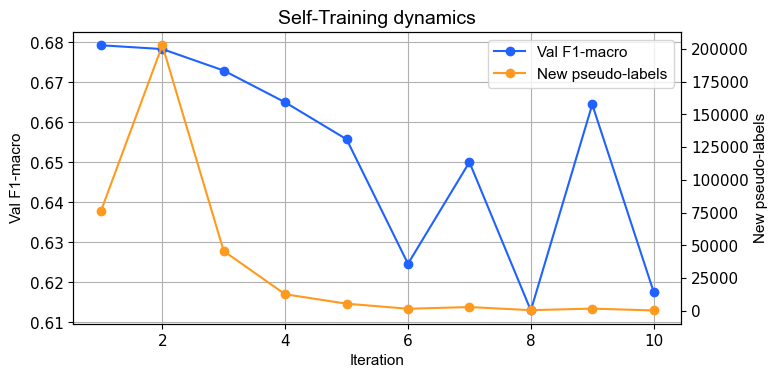

Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\data\processed\04_metrics_self_training.json
Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\data\processed\04_predictions_self_training_sample.csv
Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\data\processed\04_alerts_self_training_sample.csv


In [21]:
history = pd.DataFrame(out["history"])
pred_df = out["pred_df"]
test_metrics = out["test_metrics"]

display(history)
print("Test accuracy:", test_metrics["accuracy"])
print("Test f1_macro:", test_metrics["f1_macro"])

# Plot dynamics
fig, ax1 = plt.subplots(figsize=(8, 4))
line1 = ax1.plot(history["iter"], history["val_f1_macro"], marker="o", color="#1F62FF", label="Val F1-macro")
ax1.set_xlabel("Iteration", fontsize=11, fontfamily='Arial')
ax1.set_ylabel("Val F1-macro", fontsize=11, fontfamily='Arial')
ax1.tick_params(axis='both', labelsize=11)
ax1.grid(True)

ax2 = ax1.twinx()
line2 = ax2.plot(history["iter"], history["new_pseudo"], marker="o", color="#FF9A1F", label="New pseudo-labels")
ax2.set_ylabel("New pseudo-labels", fontsize=11, fontfamily='Arial')
ax2.tick_params(axis='y', labelsize=11)

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='best', prop={'family': 'Arial', 'size': 11})

plt.title("Self-Training dynamics", fontsize=14, fontfamily='Arial')
plt.tight_layout(pad=1.5)

# Save figure based on instructions
images_dir = PROJECT_ROOT / "images"
images_dir.mkdir(parents=True, exist_ok=True)
fig_path = images_dir / "04_self_training_dynamics.png"
fig.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {fig_path}")

plt.show()

# Save artifacts
metrics_path = (PROJECT_ROOT / METRICS_PATH).resolve()
pred_path = (PROJECT_ROOT / PRED_SAMPLE_PATH).resolve()
alerts_path = (PROJECT_ROOT / ALERTS_SAMPLE_PATH).resolve()
for p in [metrics_path, pred_path, alerts_path]:
    p.parent.mkdir(parents=True, exist_ok=True)

payload = {
    "method": "self_training",
    "data_cfg": data_cfg.__dict__,
    "st_cfg": st_cfg.__dict__,
    "history": out["history"],
    "test_metrics": test_metrics,
    "model_info": out["model_info"],
}
with open(metrics_path, "w", encoding="utf-8") as f:
    json.dump(payload, f, ensure_ascii=False, indent=2)

pred_df.head().to_csv(pred_path, index=False)
alerts = add_alert_columns(pred_df, pred_col="y_pred", severe_from=ALERT_FROM_CLASS)
alerts.head().to_csv(alerts_path, index=False)

print("Saved:", metrics_path)
print("Saved:", pred_path)
print("Saved:", alerts_path)

Biểu đồ so sánh đã được lưu tại: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\images\04_baseline_comparison.png
Dữ liệu so sánh đã được lưu tại: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\data\processed\04_baseline_comparison.csv


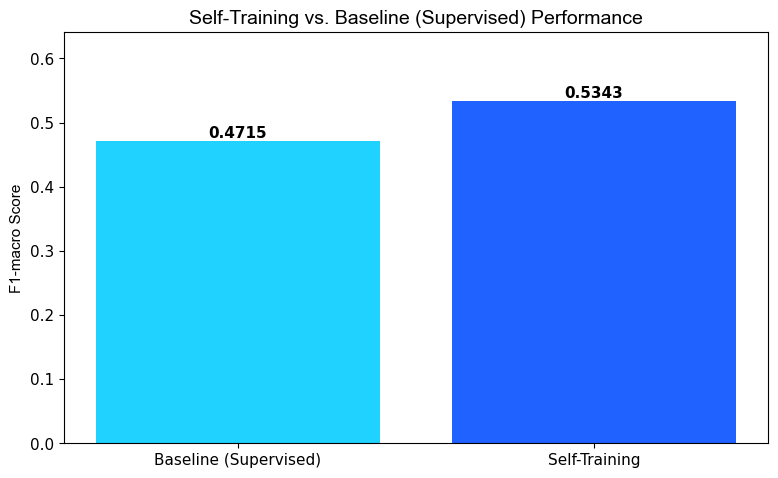

In [22]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Tải kết quả của mô hình Self-Training ---
self_training_metrics_path = PROJECT_ROOT / METRICS_PATH
with open(self_training_metrics_path, 'r', encoding='utf-8') as f:
    self_training_data = json.load(f)
self_training_f1 = self_training_data['test_metrics']['f1_macro']

# --- Tải kết quả của mô hình Baseline (Supervised) ---
baseline_metrics_path = PROJECT_ROOT / 'data' / 'processed' / '06_metrics.json'
with open(baseline_metrics_path, 'r', encoding='utf-8') as f:
    baseline_data = json.load(f)
baseline_f1 = baseline_data['f1_macro']

# --- Tạo DataFrame để so sánh ---
comparison_data = {
    'Model': ['Baseline (Supervised)', 'Self-Training'],
    'F1-macro': [baseline_f1, self_training_f1]
}
df_comparison = pd.DataFrame(comparison_data)

# --- Trực quan hóa so sánh ---
fig, ax = plt.subplots(figsize=(8, 5))
colors = ['#1FD2FF', '#1F62FF'] # Xanh nhạt cho baseline, xanh đậm cho self-training
bars = ax.bar(df_comparison['Model'], df_comparison['F1-macro'], color=colors)

# Thêm giá trị trên mỗi cột
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center', fontsize=11, fontweight='bold')

# Định dạng biểu đồ
ax.set_title('Self-Training vs. Baseline (Supervised) Performance', fontsize=14, fontfamily='Arial')
ax.set_ylabel('F1-macro Score', fontsize=11, fontfamily='Arial')
ax.set_ylim(0, max(self_training_f1, baseline_f1) * 1.2)
ax.tick_params(axis='both', labelsize=11)
plt.tight_layout(pad=1.5)

# --- Lưu kết quả ---
# Lưu biểu đồ
images_dir = PROJECT_ROOT / "images"
fig_path = images_dir / "04_baseline_comparison.png"
fig.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"Biểu đồ so sánh đã được lưu tại: {fig_path}")

# Lưu dữ liệu so sánh
csv_path = (PROJECT_ROOT / "data" / "processed" / "04_baseline_comparison.csv")
df_comparison.to_csv(csv_path, index=False)
print(f"Dữ liệu so sánh đã được lưu tại: {csv_path}")

plt.show()